# Weights

In this notebook we demonstrate all of netCDF-SCM's known weightings. These weights are used when taking area overages for different SCM boxes e.g. the ocean/land boxes or the El Nino box. 

Note: here we use the "last resort" land surface fraction values. However, if land surface fraction data is available then that is used to do land/ocean weighting rather than the "last resort" values.

This notebook is set out as follows:

1. we show the default weights
1. we show how the different available options for combining area and surface fraction information
1. we show all our inbuilt weights
1. we show how the user can define their own custom weights.

## Imports

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask

from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube
from netcdf_scm.weights import (
    AreaSurfaceFractionWeightCalculator,
    AreaWeightCalculator,
    get_weights_for_area,
    WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING,
)

In [2]:
plt.style.use("bmh")
%matplotlib inline

## Data path

Here we use our test data.

In [3]:
DATA_PATH_TEST = join("..", "..", "..", "tests", "test-data")
DATA_PATH_TEST_CMIP6_ROOT = join(DATA_PATH_TEST, "cmip6output")

## Load the cube

In [4]:
example = CMIP6OutputCube()
example.load_data_in_directory(
    join(
        DATA_PATH_TEST_CMIP6_ROOT,
        #         "CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp126/r1i1p1f1/Amon/example/gn/v20190314",
        "CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313",
    )
)

Interpolate the cube to get higher resolution data.

In [5]:
sample_points = [
    ("longitude", np.arange(0, 360, 2)),
    ("latitude", np.arange(-90, 90 + 1, 2)),
]
example.cube = example.cube.interpolate(sample_points, iris.analysis.Linear())

## Weights

### Default weights

By default, only land/ocean and hemispheric weights are considered.

In [6]:
# NBVAL_IGNORE_OUTPUT
default_weights = example.get_scm_timeseries_weights()

/Users/znicholls/miniconda3/envs/netcdf-scm/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


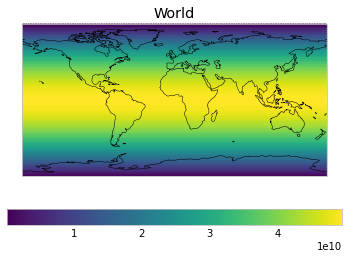

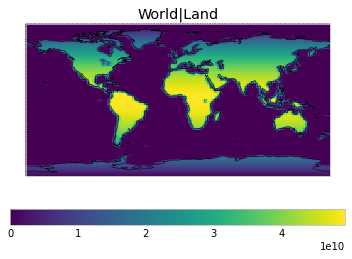

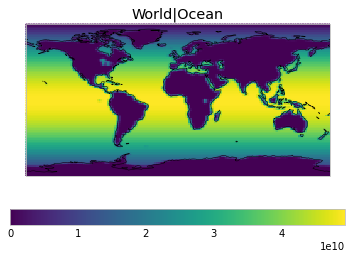

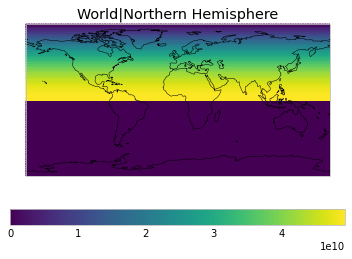

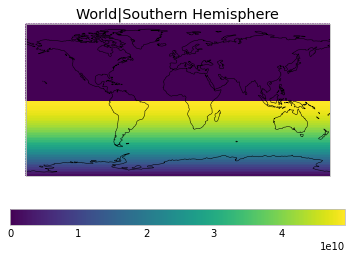

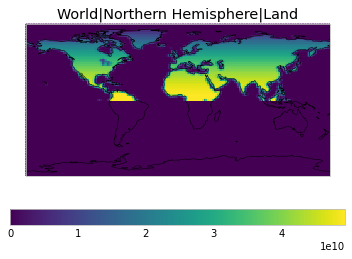

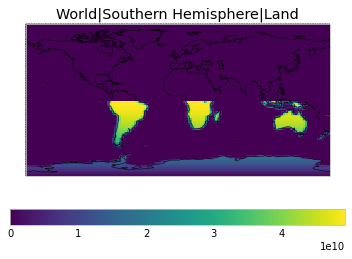

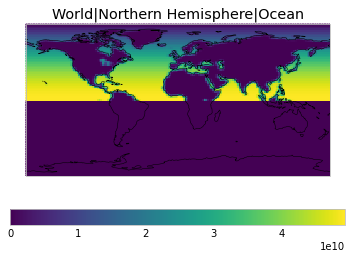

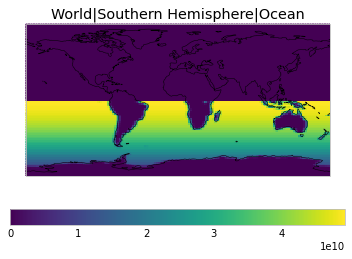

In [7]:
# NBVAL_IGNORE_OUTPUT
def plot_weights(weights_to_plot, constraint=None, axes=None, **kwargs):
    for i, (label, weights) in enumerate(weights_to_plot.items()):
        if axes is None:
            ax = plt.figure().add_subplot(111)
        else:
            ax = axes[i]

        weight_cube = example.cube.collapsed("time", iris.analysis.MEAN)
        weight_cube.data = weights
        weight_cube.units = ""
        if constraint is not None:
            weight_cube = weight_cube.extract(constraint)

        plt.sca(ax)

        qplt.pcolormesh(
            weight_cube, **kwargs,
        )

        plt.gca().set_title(label)
        plt.gca().coastlines()


plot_weights(default_weights)

### Area and surface fraction combination options

By defaults, the weights are calculated as the combination of area and surface fractions using ``netcdf_scm.weights.AreaSurfaceFractionWeightCalculator``.

In [8]:
# NBVAL_IGNORE_OUTPUT
print(AreaSurfaceFractionWeightCalculator.__doc__)


    Calculates weights which are both area and surface fraction weighted

    .. math::

        w(lat, lon) = a(lat, lon) \\times s(lat, lon)

    where :math:`w(lat, lon)` is the weight of the cell at given latitude and
    longitude, :math:`a` is area of the cell and :math:`s` is the surface
    fraction of the cell (e.g. fraction of ocean area for ocean based regions).
    


For land/ocean weights, this causes regions on coastlines to have weights less than their area weight, because they are not fully land or ocean.

The user can instead use ``netcdf_scm.weights.AreaWeightCalculator``, which focusses on area weights but removes any areas that have a surface fraction of zero.

In [9]:
# NBVAL_IGNORE_OUTPUT
print(AreaWeightCalculator.__doc__)


    Calculates weights which are area weighted but surface fraction aware.

    This means that any cells which have a surface fraction of zero will
    receive zero weight, otherwise cells are purely area weighted.

    .. math::

        w(lat, lon) = \\begin{cases}
            a(lat, lon), & s(lat, lon) > 0 \\\\
            0, & s(lat, lon) = 0
        \\end{cases}

    where :math:`w(lat, lon)` is the weight of the cell at given latitude and
    longitude, :math:`a` is area of the cell and :math:`s` is the surface
    fraction of the cell (e.g. fraction of ocean area for ocean based regions).
    


In [10]:
# NBVAL_IGNORE_OUTPUT
area_weights = example.get_scm_timeseries_weights(cell_weights="area-only")

/Users/znicholls/miniconda3/envs/netcdf-scm/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


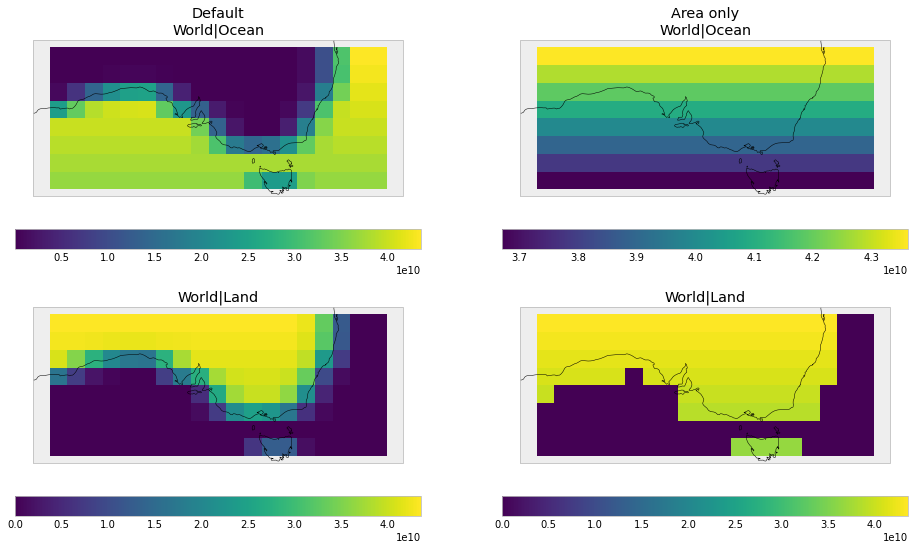

In [11]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots(figsize=(16, 9), nrows=2, ncols=2)

for i, (w, title) in enumerate(
    ((default_weights, "Default"), (area_weights, "No land fraction"))
):
    plt_weights = {k: w[k] for k in ["World|Ocean", "World|Land"]}
    zoom_constraint = iris.Constraint(
        latitude=lambda cell: -45 < cell < -25
    ) & iris.Constraint(longitude=lambda cell: 120 < cell < 160)
    plot_weights(
        plt_weights, constraint=zoom_constraint, axes=[axes[0][i], axes[1][i]],
    )

cf = plt.gcf()
for i, (w, title) in enumerate(
    ((default_weights, "Default"), (area_weights, "Area only"))
):
    title_ax = cf.axes[i * 4]
    title_ax.set_title("{}\n{}".format(title, title_ax.get_title()))

### All inbuilt masks

The default masks do not contain all inbuilt masks. We also provide masks for the IPCC AR6 regions, as defined in [Iturbide et al. (2020)](https://essd.copernicus.org/preprints/essd-2019-258/), as well as country-level (at the 50m scale) masks defined by [Natural Earth](https://www.naturalearthdata.com/). For both these masks, we use the [regionmask](https://regionmask.readthedocs.io/en/stable/defined_scientific.html) implementation.

The regionmask names can be inspected as shown below. Not that the abbreviations for the countries are not unique.

In [12]:
regionmask_countries = (
    pd.DataFrame(
        {
            "name": regionmask.defined_regions.natural_earth.countries_50.names,
            "abbreviation": regionmask.defined_regions.natural_earth.countries_50.abbrevs,
        }
    )
    .sort_values(by="name")
    .reset_index(drop=True)
)
regionmask_countries

name abbreviation
0       Afghanistan           AF
1           Albania           AL
2           Algeria           DZ
3    American Samoa           AS
4           Andorra          AND
..              ...          ...
236           Yemen           YE
237          Zambia           ZM
238        Zimbabwe           ZW
239        eSwatini           SW
240           Åland           AI

[241 rows x 2 columns]

Below we show a selection of plots for the regions we include.

In [13]:
selection_inbuilt_weights = example.get_scm_timeseries_weights(
    regions=[
        "World",
        "World|Northern Hemisphere",
        "World|Southern Hemisphere",
        "World|Land",
        "World|Ocean",
        "World|Northern Hemisphere|Land",
        "World|Southern Hemisphere|Land",
        "World|Northern Hemisphere|Ocean",
        "World|Southern Hemisphere|Ocean",
        "World|North Atlantic Ocean",
        "World|El Nino N3.4",
        "World|AR6|GIC",
        "World|AR6|NWN",
        "World|AR6|NEN",
        "World|AR6|WNA",
        "World|AR6|SSA",
        "World|AR6|NEU",
    ]
    + [
        "World|Natural Earth 50m|{}".format(c)
        for c in [
            "Australia",
            "Austria",
            "China",
            "New Zealand",
            "United States of America",
            # this fails as the region is tiny and
            # our data is not high-resolution enough to capture it
            "Vatican",
            "Vietnam",
        ]
    ]
)

/Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/src/netcdf_scm/weights/__init__.py:869: UserWarning: Failed to create 'World|Natural Earth 50m|Vatican' weights: All weights are zero for region: `World|Natural Earth 50m|Vatican`
  warnings.warn(warn_str)


<ipython-input-7-e10806626a7c>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.figure().add_subplot(111)


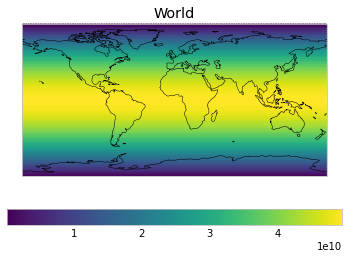

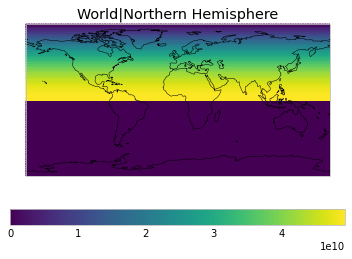

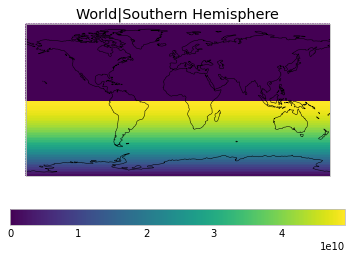

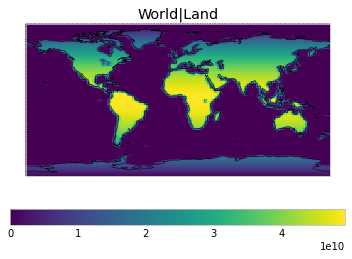

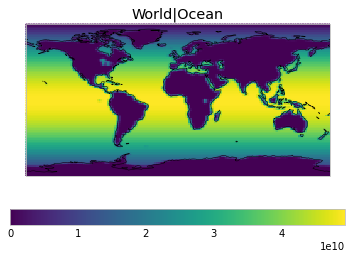

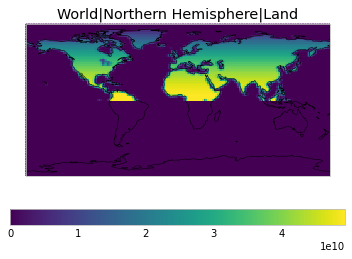

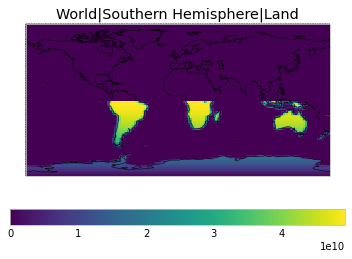

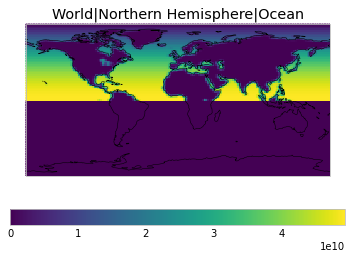

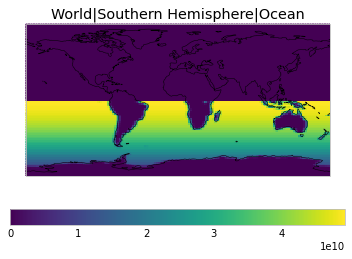

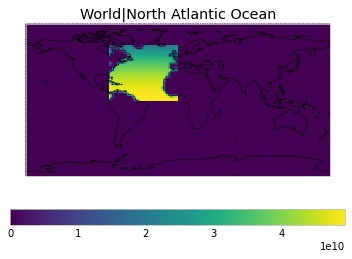

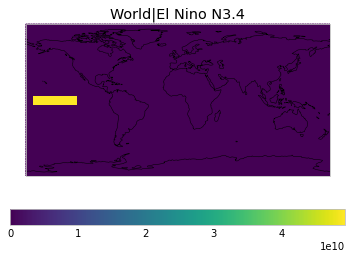

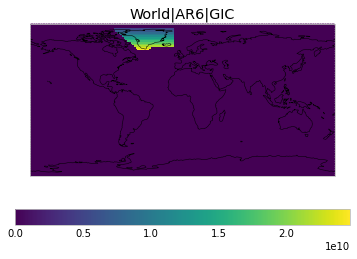

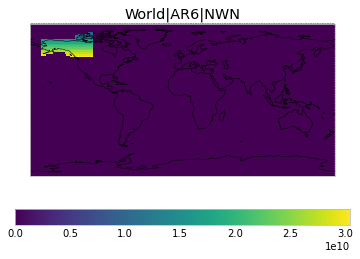

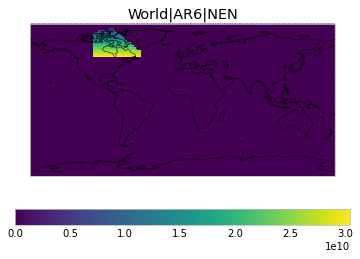

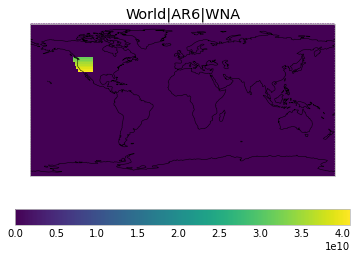

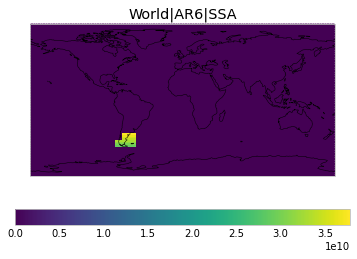

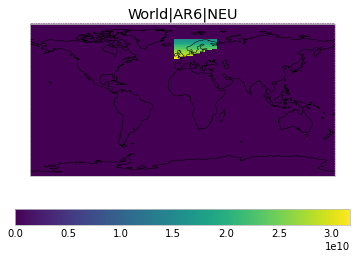

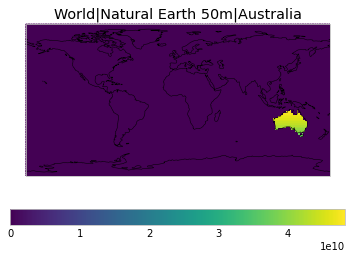

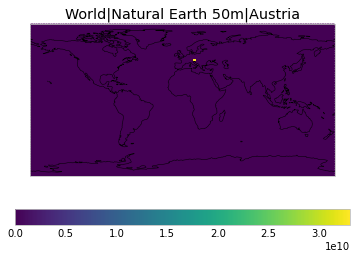

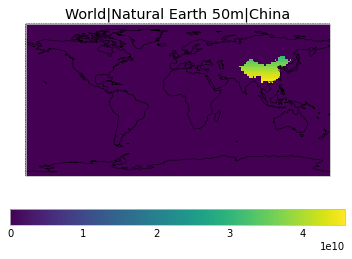

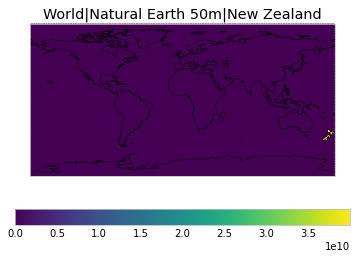

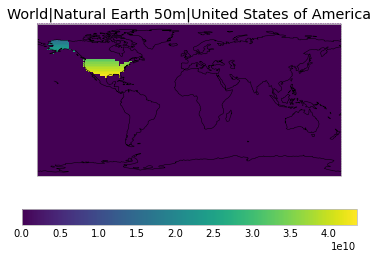

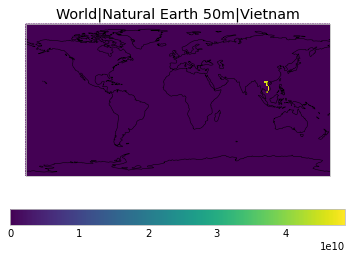

In [14]:
# NBVAL_IGNORE_OUTPUT
plot_weights(selection_inbuilt_weights)

In [15]:
# full list of available regions
sorted(list(WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING.keys()))

['World',
 'World|AR6|ARO',
 'World|AR6|ARP',
 'World|AR6|ARS',
 'World|AR6|BOB',
 'World|AR6|CAF',
 'World|AR6|CAR',
 'World|AR6|CAU',
 'World|AR6|CNA',
 'World|AR6|EAN',
 'World|AR6|EAO',
 'World|AR6|EAS',
 'World|AR6|EAU',
 'World|AR6|ECA',
 'World|AR6|EEU',
 'World|AR6|EIO',
 'World|AR6|ENA',
 'World|AR6|EPO',
 'World|AR6|ESAF',
 'World|AR6|ESB',
 'World|AR6|GIC',
 'World|AR6|MDG',
 'World|AR6|MED',
 'World|AR6|NAO',
 'World|AR6|NAU',
 'World|AR6|NCA',
 'World|AR6|NEAF',
 'World|AR6|NEN',
 'World|AR6|NES',
 'World|AR6|NEU',
 'World|AR6|NPO',
 'World|AR6|NSA',
 'World|AR6|NWN',
 'World|AR6|NWS',
 'World|AR6|NZ',
 'World|AR6|RAR',
 'World|AR6|RFE',
 'World|AR6|SAH',
 'World|AR6|SAM',
 'World|AR6|SAO',
 'World|AR6|SAS',
 'World|AR6|SAU',
 'World|AR6|SCA',
 'World|AR6|SEA',
 'World|AR6|SEAF',
 'World|AR6|SES',
 'World|AR6|SIO',
 'World|AR6|SOO',
 'World|AR6|SPO',
 'World|AR6|SSA',
 'World|AR6|SWS',
 'World|AR6|TIB',
 'World|AR6|WAF',
 'World|AR6|WAN',
 'World|AR6|WCA',
 'World|AR6|WCE'

### User-defined masks

As a user, you can also define weights. Simply add them to `netcdf_scm.WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING.WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING` and then use them in your `get_scm_cubes` call.

In [16]:
WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING["custom mask"] = get_weights_for_area(
    -60, 100, -10, 330
)
WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING[
    "Northern Atlantic area bounds"
] = get_weights_for_area(0, -80, 65, 0)

In [17]:
custom_weights = example.get_scm_timeseries_weights(
    regions=[
        "World|El Nino N3.4",
        "custom mask",
        "World|Land",
        "Northern Atlantic area bounds",
    ]
)

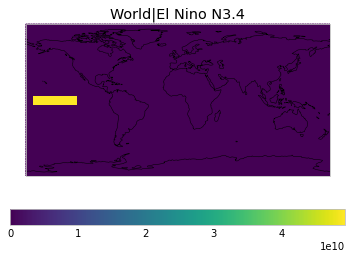

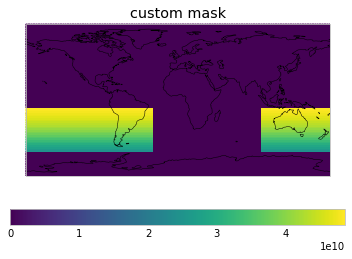

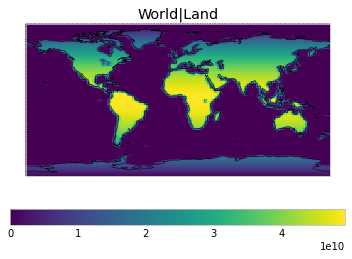

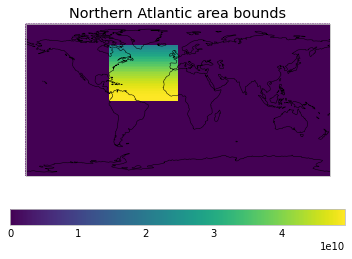

In [18]:
plot_weights(custom_weights)